# How to build custom Datasets for Text in Pytorch

[Original video](https://youtu.be/9sHcLvVXsns)

[Flickr8k Dataset used](https://www.kaggle.com/dataset/e1cd22253a9b23b073794872bf565648ddbe4f17e7fa9e74766ad3707141adeb)

We want to convert text to numerical values.

1. We need a Vocabulary mapping each word to an index.
2. We need to setup PyTorch dataset to load the data.
3. Setup padding of every batch (all examples should be of the same seq_len and setup dataloader).


In [14]:
# Get dataset from Kaggle

# Install kaggle packages if necessary. Not necessary for CoLab
# !pip install -q kaggle
# !pip install -q kaggle-cli

# Colab's file access feature
from google.colab import files

# Upload `kaggle.json` file
uploaded = files.upload()

# Retrieve uploaded file and print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


# Then copy kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# Download the dataset
#!kaggle datasets list -s flickr8k
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

kaggle.json
100% 1.03G/1.04G [00:45<00:00, 11.1MB/s]
100% 1.04G/1.04G [00:45<00:00, 24.5MB/s]


In [15]:
# Unzip
import zipfile

with zipfile.ZipFile('flickr8kimagescaptions.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [48]:
import os  # for file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
import torchvision.transforms as transforms
import multiprocessing  # get number of CPU workers for text processing
import matplotlib.pyplot as plt  # show images from the tensor

from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # load images

In [49]:
class Vocabulary:
    def __init__(self, freq_threshold):
        # itos - index to string, UNK - unknown, PAD - padding
        self.itos = {0:'<PAD>', 1:'<SOS>', 2:'<EOS>', 3:'<UNK>'}
        # stoi - string to index
        self.stoi = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3}
        self.freq_threshold = freq_threshold
        # Download if necessary with:
        #   !python -m spacy download en
        self.spacy_eng = spacy.load('en')

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        # 'I love peanuts' ==> ['i', 'love', 'peanuts']
        return [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequences = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequences:
                    frequences[word] = 1
                else:
                    frequences[word] += 1

                if frequences[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in tokenized_text]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get image and caption columns
        self.imgs = self.df['image']
        self.captions = self.df['caption']

        # Initialize and build vocabulary
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_name = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_name)).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # stoi means 'string to index'
        # SOS means 'start of the sentence', EOS means 'end of the sentence'
        numericalized_caption = [self.vocab.stoi['<SOS>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi['<EOS>'])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        # imgs.shape == torch.Size([batch, 3, 224, 224])
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        # batch_first=False ==> torch.Size([max-target, batch])
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(root_folder,
               annotation_file,
               transform,
               batch_size=32,
               num_workers=multiprocessing.cpu_count(),
               shuffle=True,
               pin_memory=True):

    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    pad_idx = dataset.vocab.stoi['<PAD>']
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    return loader

In [51]:
# Resize each image and convert it to tensor
# If error: AttributeError: 'Compose' object has no attribute 'Compose
# then read this: https://stackoverflow.com/a/53497727/7550928
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),])

dataloader = get_loader('flickr8k/images',
                        annotation_file='flickr8k/captions.txt',
                        transform=transform)

torch.Size([32, 3, 224, 224])
torch.Size([27, 32])


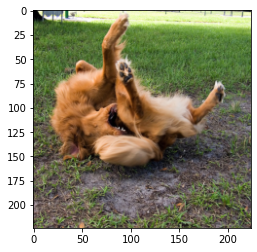

torch.Size([32, 3, 224, 224])
torch.Size([23, 32])


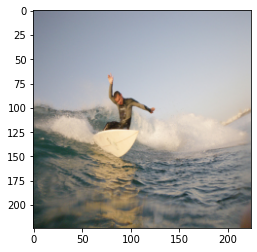

torch.Size([32, 3, 224, 224])
torch.Size([26, 32])


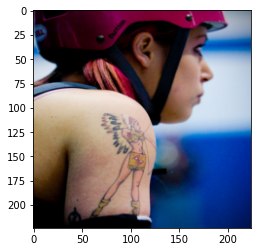

torch.Size([32, 3, 224, 224])
torch.Size([22, 32])


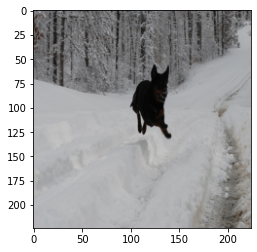

torch.Size([32, 3, 224, 224])
torch.Size([27, 32])


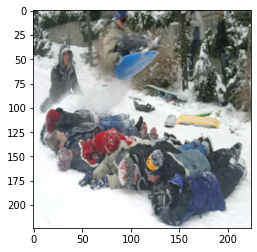

torch.Size([32, 3, 224, 224])
torch.Size([20, 32])


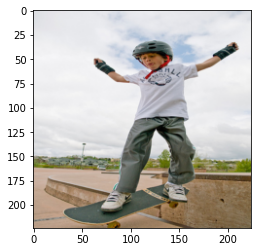

torch.Size([32, 3, 224, 224])
torch.Size([31, 32])


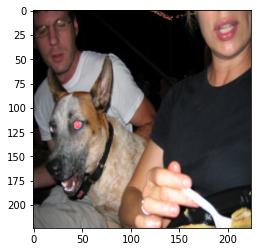

torch.Size([32, 3, 224, 224])
torch.Size([21, 32])


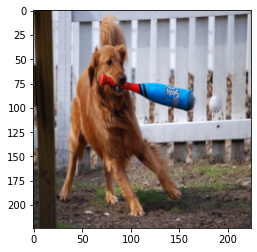

torch.Size([32, 3, 224, 224])
torch.Size([26, 32])


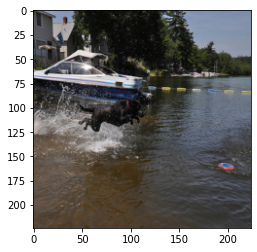

torch.Size([32, 3, 224, 224])
torch.Size([23, 32])


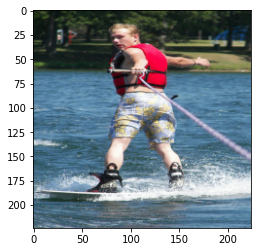

torch.Size([32, 3, 224, 224])
torch.Size([27, 32])


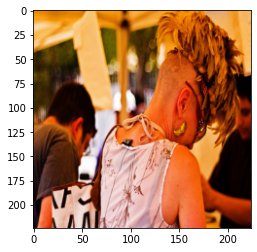

torch.Size([32, 3, 224, 224])
torch.Size([21, 32])


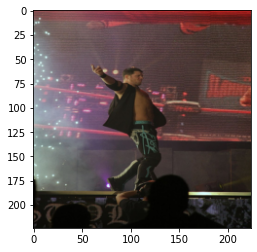

In [53]:
# Check it
for idx, (imgs, captions) in enumerate(dataloader):
    print(imgs.shape)
    print(captions.shape)
    plt.imshow(imgs[0].permute(1, 2, 0))  # show 1st image in the batch
    plt.show()
    if idx > 10:
        break